# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_35967/938709085.py:1: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.core.db import APMDB
from apm.core.io import get_files, load_eeg_demo_data
from apm.run import run_measures, compute_all_corrs, compute_corrs_to_feature, compute_diffs_to_feature
from apm.plts import plot_dots
from apm.utils import format_corr
from apm.methods import specparam, lempelziv, hjorth_complexity, dfa, hurst, irasa, app_entropy
from apm.methods.periodic import alpha_power

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Define the data folder
folder = '/Users/tom/Data/VoytekLab/ExtractedSubsets/eeg_data'

In [5]:
# Define data field to extract from files
data_field = 'oz_rest_data'

In [6]:
# Define data information
fs = 500
n_seconds = 120

In [7]:
# Define times vector for data
times = create_times(n_seconds, fs)

In [8]:
# Add plot kwargs
dot_kwargs = {
    'alpha' : 0.75,
}

In [9]:
# Settings for saving figures
SAVE_FIG = False
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '31_eeg_data'

## Load Data


In [10]:
# Get the list of available files
files = get_files(folder, select='.mat')

In [11]:
# FIX: temporarily drop subject which has a data quirk (wrong size array)
files.remove('1009.mat')

In [12]:
# Check the number of subjects
n_subjs = len(files)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 28


In [13]:
# Load data
data = load_eeg_demo_data(files, folder, data_field)

## Data Checks

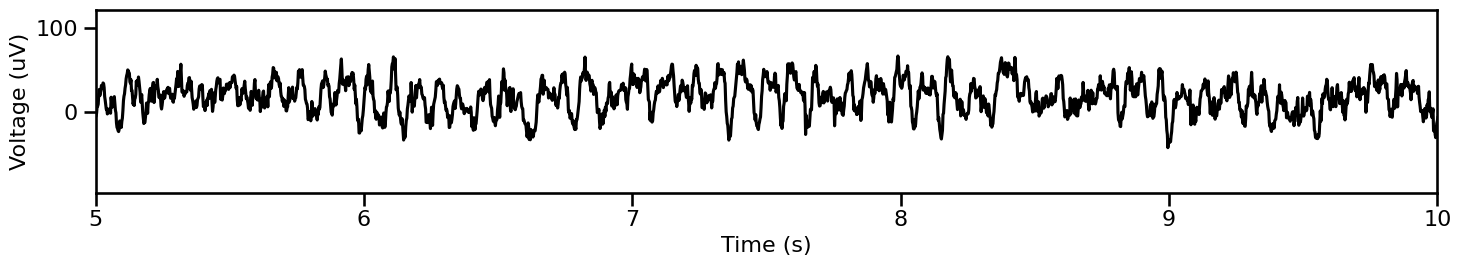

In [14]:
# Plot a segment of time series data
plot_time_series(times, data[0, :], xlim=[5, 10])

In [15]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[0, :], fs, nperseg=2*fs, noverlap=fs)

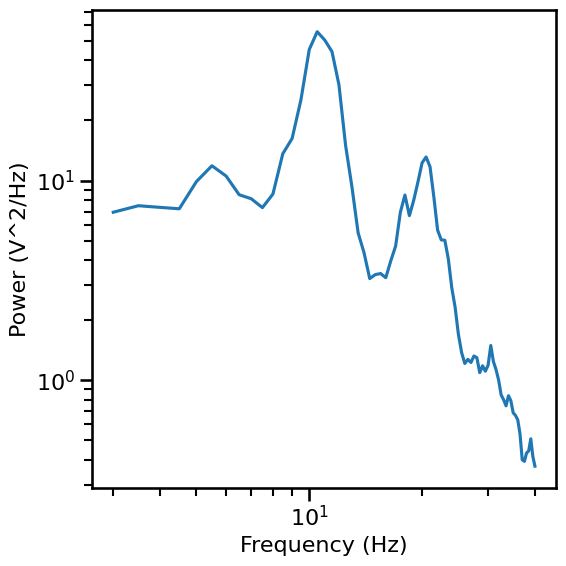

In [16]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]))

## Compare Methods

In [17]:
# General method settings
f_range = [3, 40]

In [18]:
# # Initialize specparam model
# fm = FOOOF(verbose=False)

In [19]:
# Define measures to apply, along with input parameters
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [20]:
# Compute measures of interest on the data
results = run_measures(data, measures)

In [21]:
# Compute correlations across all pairs of methods
all_corrs = compute_all_corrs(results)

#### Compare Exponent Measures

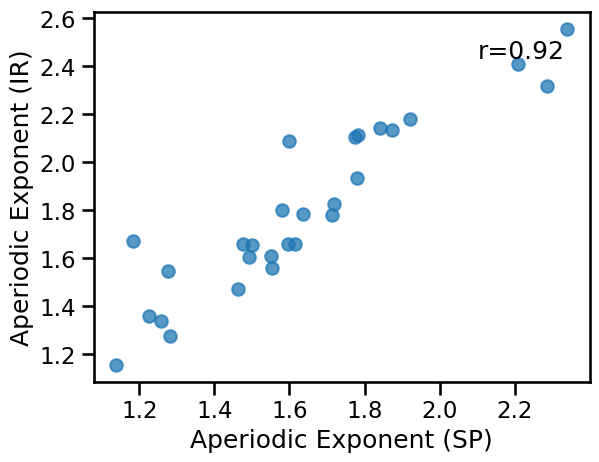

In [22]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs,
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + EXT, file_path=FIGPATH)

In [23]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.920  CI[+0.769, +0.981],  p=0.000


#### Compare exponent to LZ Complexity

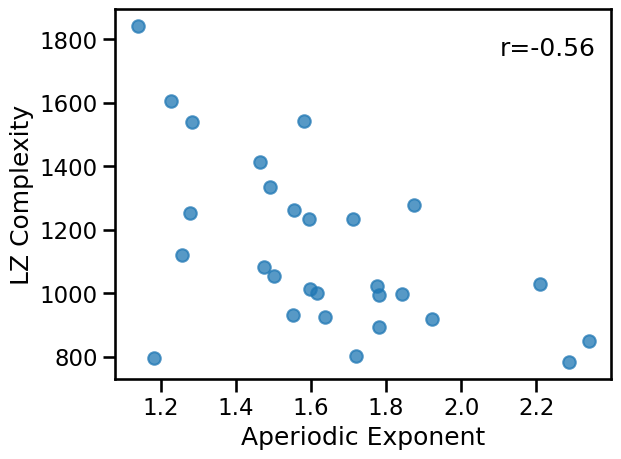

In [24]:
# Plot the comparison of specparam and lempel-ziv complexity
plot_dots(results['specparam'], results['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity',
          save_fig=SAVE_FIG, file_name='eeg_exp_lz_comp' + EXT, file_path=FIGPATH)

In [25]:
# Check the correlation
print('  SP-EXP & LZC:  ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  IR-EXP & LZC:  ', format_corr(*all_corrs['irasa']['lempelziv']))

  SP-EXP & LZC:   r=-0.561  CI[-0.845, -0.174],  p=0.002
  IR-EXP & LZC:   r=-0.649  CI[-0.847, -0.337],  p=0.000


#### Compare exponent to entropy

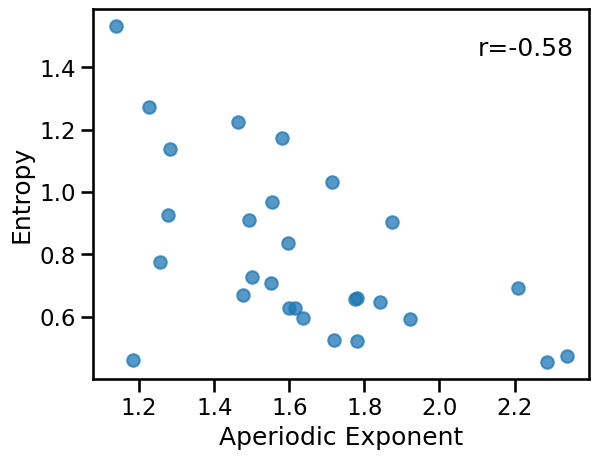

In [26]:
# Plot the comparison of specparam and approximate entropy
plot_dots(results['specparam'], results['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Entropy',
          save_fig=SAVE_FIG, file_name='eeg_exp_ent_comp' + EXT, file_path=FIGPATH)

In [27]:
# Check the correlation between approximate entropy and exponent measures
print('  SP-EXP & ENT:  ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  IR-EXP & ENT:  ', format_corr(*all_corrs['irasa']['app_entropy']))

  SP-EXP & ENT:   r=-0.577  CI[-0.845, -0.179],  p=0.001
  IR-EXP & ENT:   r=-0.691  CI[-0.859, -0.409],  p=0.000


## Compare to Alpha Power

### Compute Alpha Power

In [28]:
# Define periodic measures to compute
peak_measures = {alpha_power : measures[specparam]}

In [29]:
# Compute periodic measures
peak_results = run_measures(data, peak_measures)

In [30]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [31]:
# Compute differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [32]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     specparam           :   r=+0.159  CI[-0.288, +0.555],  p=0.418
     irasa               :   r=+0.218  CI[-0.222, +0.607],  p=0.265
     hurst               :   r=-0.691  CI[-0.872, -0.373],  p=0.000
     dfa                 :   r=-0.162  CI[-0.564, +0.254],  p=0.410
     lempelziv           :   r=+0.069  CI[-0.343, +0.501],  p=0.727
     hjorth_complexity   :   r=-0.039  CI[-0.468, +0.379],  p=0.842
     app_entropy         :   r=-0.025  CI[-0.432, +0.418],  p=0.901


## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.